<h1>Musical analysis</h1>

Total Eclipse - Freefalling Upwards

https://www.youtube.com/watch?v=bZ_e-4Y-jq4&list=RDbZ_e-4Y-jq4&start_radio=1

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os

%matplotlib inline

# Enable autoreload of imported modules
%load_ext autoreload
%autoreload 2

from main_julia import AudioAnalyzer 
from main_julia import TRACK_PRESETS

audio_file = "music/TheMysteryoftheYetiPart2_track3.wav"
analyzer = AudioAnalyzer(audio_file)

[Trends] Low/Med=0.030  Med/High=0.050


We save the following data from the audio file:
- y - discrete audio signal (audio file is represented as real numbers in a N - dimensional array)
- sr - sampling rate (Hz) 
- duration - computed as $\frac{|y|}{sr}$
- hop - determines the time grid (sampling the signal in time blocks)
- RMS (energy or volume) - this approximates loudness
- spectrogram - visualization of FT
- onset envelope - measures how much the energy of the signal is changing over time 

In [3]:
print(f"Duration: {analyzer.duration:.2f} seconds")
print(f"Sample rate: {analyzer.sr} Hz")
print(f"Number of RMS frames: {len(analyzer.rms)}")

Duration: 913.00 seconds
Sample rate: 48000 Hz
Number of RMS frames: 85594


<h2>RMS</h2>

RMS approximates loudness and is computed over short time windows/frames. 

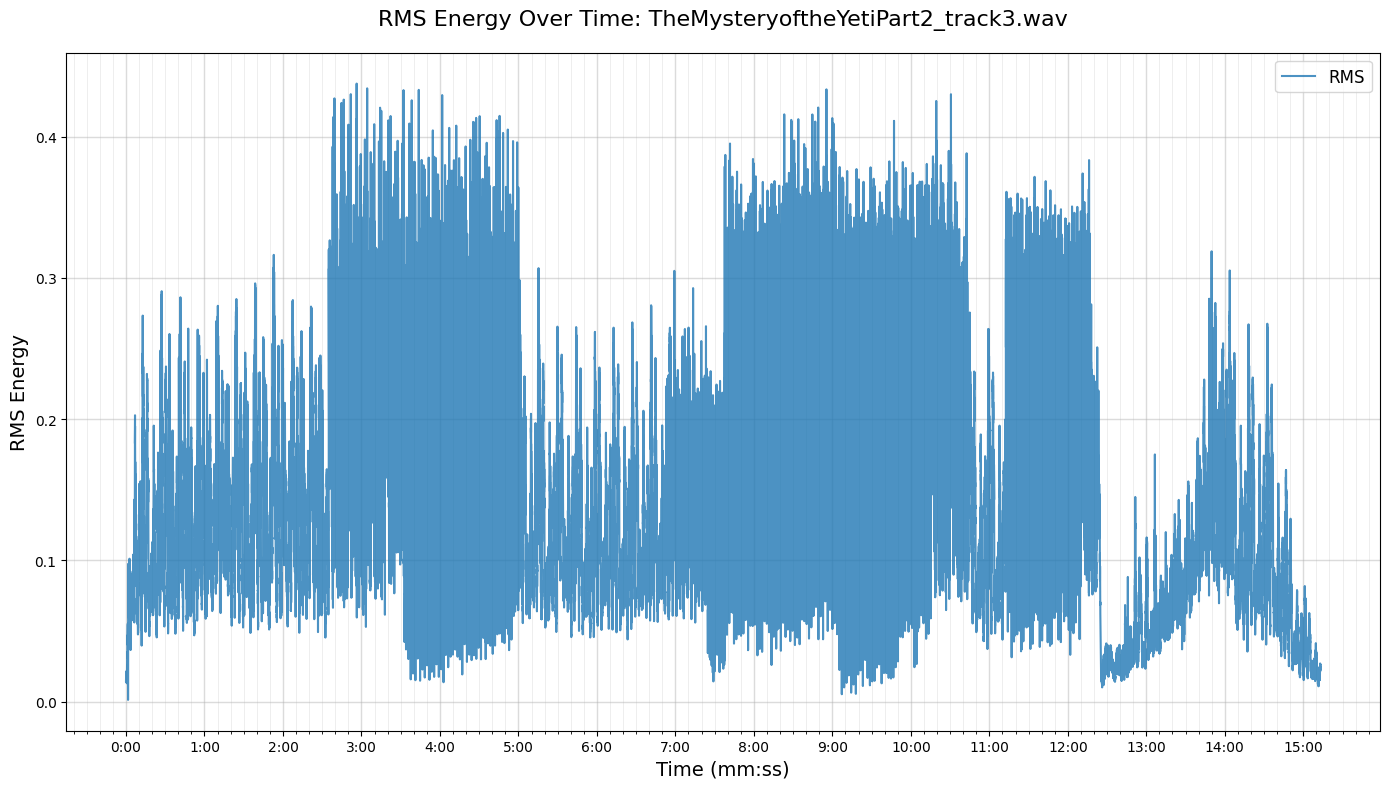

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter


time_rms = np.arange(len(analyzer.rms)) * analyzer.hop / analyzer.sr

def mmss(x, pos):
    m = int(x // 60)
    s = int(x % 60)
    return f"{m}:{s:02d}"


fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(
    time_rms,
    analyzer.rms,
    linewidth=1.5,
    alpha=0.8,
    label="RMS"
)

ax.xaxis.set_major_locator(MultipleLocator(60))   # 1 minute
ax.xaxis.set_minor_locator(MultipleLocator(10))   # 10 seconds
ax.xaxis.set_major_formatter(FuncFormatter(mmss))

ax.set_xlabel("Time (mm:ss)", fontsize=14)
ax.set_ylabel("RMS Energy", fontsize=14)
ax.set_title(
    f"RMS Energy Over Time: {os.path.basename(audio_file)}",
    fontsize=16,
    pad=20
)

ax.grid(True, which="major", alpha=0.45, linewidth=1.0)
ax.grid(True, which="minor", alpha=0.25, linewidth=0.6)

ax.legend(fontsize=12, loc="upper right")

plt.tight_layout()
plt.show()


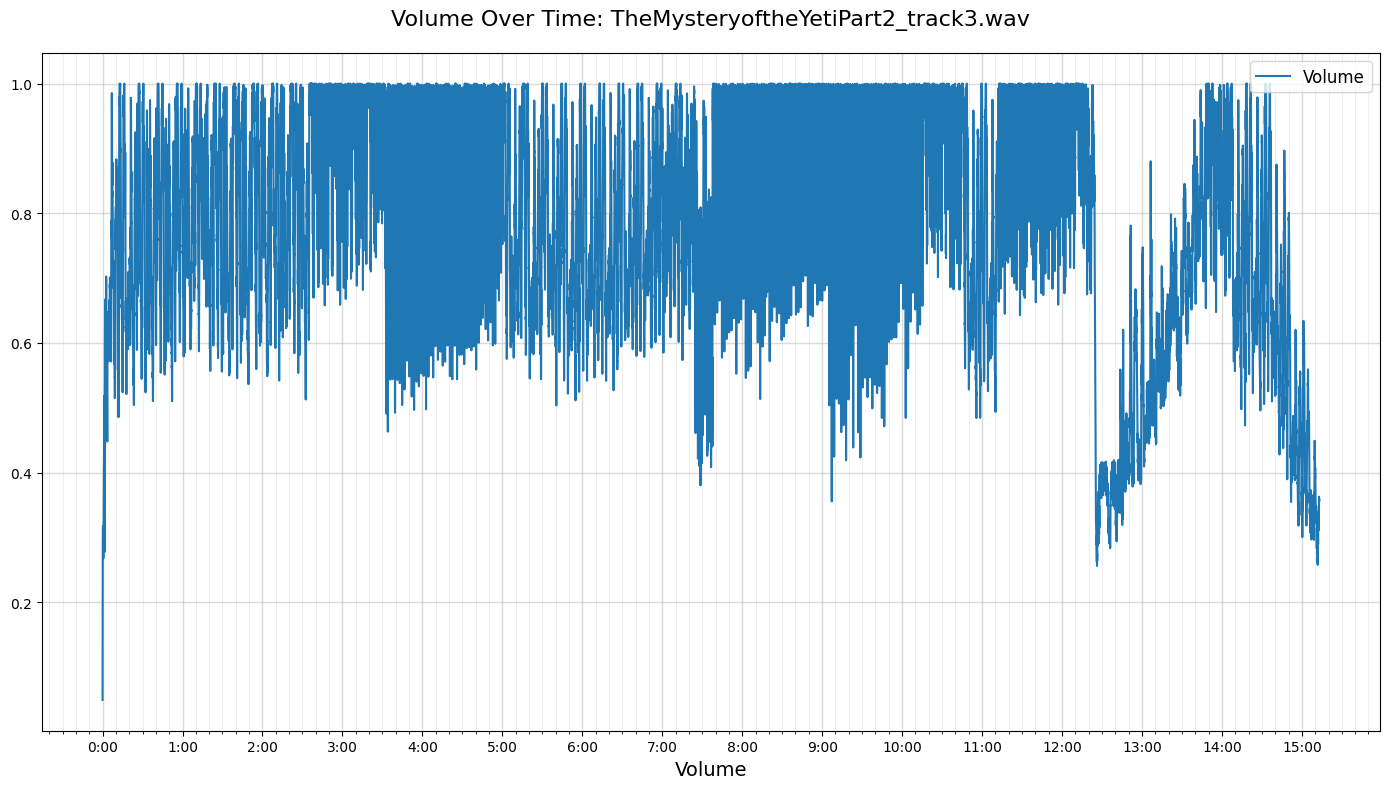

In [5]:

def plot_volume(analyzer, dt=0.01):
    t_values = np.arange(0, analyzer.duration, dt)
    volume = np.array([analyzer.features_at(t)["volume"] for t in t_values])

    _, ax = plt.subplots(figsize=(14, 8))
    ax.plot(t_values, volume, label='Volume')

    ax.xaxis.set_major_locator(MultipleLocator(60))   # 1 minute
    ax.xaxis.set_minor_locator(MultipleLocator(10))   # 10 seconds
    ax.xaxis.set_major_formatter(FuncFormatter(mmss))

    ax.set_xlabel("Time (s)", fontsize=14)
    ax.set_xlabel("Volume", fontsize=14)
    ax.set_title(
    f"Volume Over Time: {os.path.basename(audio_file)}",
    fontsize=16,
    pad=20
)

    ax.grid(True, which="major", alpha=0.45, linewidth=1.0)
    ax.grid(True, which="minor", alpha=0.25, linewidth=0.6)
    ax.legend(fontsize=12, loc="upper right")

    plt.tight_layout()
    plt.show()

plot_volume(analyzer)

<h2>Spectrogram</h2>
A spectrogram is a way to visualize how the energy of different 
frequency components in a sound signal changes over time.

- We take short overlapping blocks of the audio signal and compute a Fourier
  transform (STFT) for each block.
- Each Fourier transform gives us the amplitude of all frequencies in that block.
- The spectrogram is the collection of these amplitudes over time: a 2D array
  where rows correspond to frequencies, and columns correspond to time frames.
- By averaging over frequency ranges (low, mid, high), we can extract features
  that represent the energy in those bands at each moment.

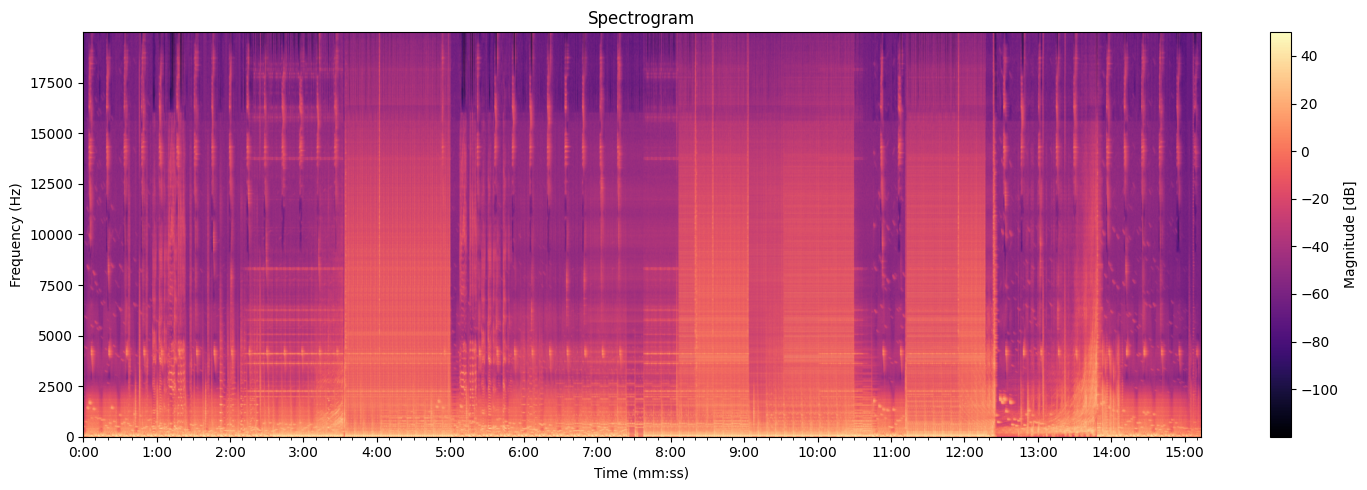

In [6]:
from matplotlib.ticker import MultipleLocator, FuncFormatter

def plot_spectrogram(analyzer, max_freq=20000):
    freqs = analyzer.freqs
    spec = analyzer.spec
    idx_max = np.searchsorted(freqs, max_freq)

    fig, ax = plt.subplots(figsize=(15, 5))

    im = ax.imshow(
        20 * np.log10(spec[:idx_max, :] + 1e-6),
        origin='lower',
        aspect='auto',
        extent=[0, analyzer.duration, freqs[0], freqs[idx_max - 1]],
        cmap='magma'
    )

    fig.colorbar(im, ax=ax, label="Magnitude [dB]")

    ax.xaxis.set_major_locator(MultipleLocator(60))   # 1 minute
    ax.xaxis.set_minor_locator(MultipleLocator(10))   # 10 seconds
    ax.xaxis.set_major_formatter(FuncFormatter(mmss))

    ax.set_xlabel("Time (mm:ss)")
    ax.set_ylabel("Frequency (Hz)")
    ax.set_title("Spectrogram")

    ax.grid(False)  

    plt.tight_layout()
    plt.show()

plot_spectrogram(analyzer)


Reading a spectogram (visualization of Fourier Transform):
- **x-axis: time**: major ticks = 1 minute, minor ticks = 10 seconds.
- **y-axis: frequency**: Low notes are at the bottom (low frequency), high notes at the top (high frequency).
- **Color / brightness**: represents amplitude (volume or energy) at that frequency and time.

We can interpret darker areas as having low energy and brighter areas as having high energy.

Interpretation:

1. **Horizontal lines** - sustained notes or bass lines over the entierty of the track.  
2. **Vertical spikes** - sudden sounds or percussive hits .  
3. **Dense bright areas** - high-energy or fast sections.  
4. **Sparse dark areas** - calm or quiet sections.  
5. **Shifts in color from blue/purple → yellow/orange/red** - music getting louder or more “intense”.  


<h2>Spectrogram - making of three bands</h2>

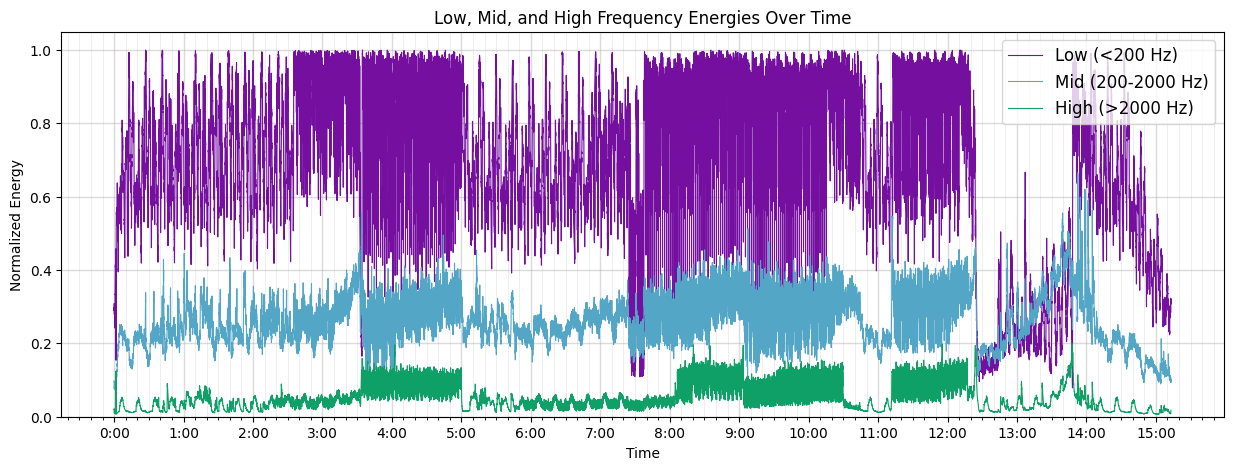

In [7]:
from matplotlib.ticker import MultipleLocator, FuncFormatter

def plot_frequency_bands(analyzer, dt=0.01):
    t_values = np.linspace(0, analyzer.duration, int(analyzer.duration / dt) + 1)

    low_vals = []
    mid_vals = []
    high_vals = []

    for t in t_values:
        f = analyzer.features_at(t)
        low_vals.append(f["low"])
        mid_vals.append(f["mid"])
        high_vals.append(f["high"])

    low_vals = np.array(low_vals)
    mid_vals = np.array(mid_vals)
    high_vals = np.array(high_vals)

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(t_values, low_vals, color="#740FA0", label='Low (<200 Hz)', lw=0.8)
    ax.plot(t_values, mid_vals, color="#54A6C7", label='Mid (200-2000 Hz)', lw=0.8)
    ax.plot(t_values, high_vals, color="#0FA068", label='High (>2000 Hz)', lw=0.8)

    # Labels and grid
    ax.set_xlabel("Time")
    ax.set_ylabel("Normalized Energy")
    ax.set_title("Low, Mid, and High Frequency Energies Over Time")
    ax.set_ylim(0, 1.05)
    ax.grid(True, which="major", alpha=0.45, linewidth=1.0)
    ax.grid(True, which="minor", alpha=0.25, linewidth=0.6)
    ax.legend(fontsize=12, loc="upper right")

    ax.xaxis.set_major_locator(MultipleLocator(60))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x//60)}:{int(x%60):02}"))

    plt.show()

plot_frequency_bands(analyzer)

<h2>Onset envelope </h2>
The onset envelope detects "kicks": it tells you when the music suddenly jumps in energy.
Each value corresponds in the array to a short window in time.
Brighter/more positive values = strong events.

We decide we divide the chosen track into three "global energy trends": low, medium and high. 
These trends speak about the global progression structure of the chosen track. 

We achieve this by smoothing out the onset envelope and choosing two parameters par33 and par66,
which detemine where the cutoff line will be between LOW and MEDIUM (par33) and MEDIUM and HIGH (par66).
For best results we should check the graph below to choose correct values.


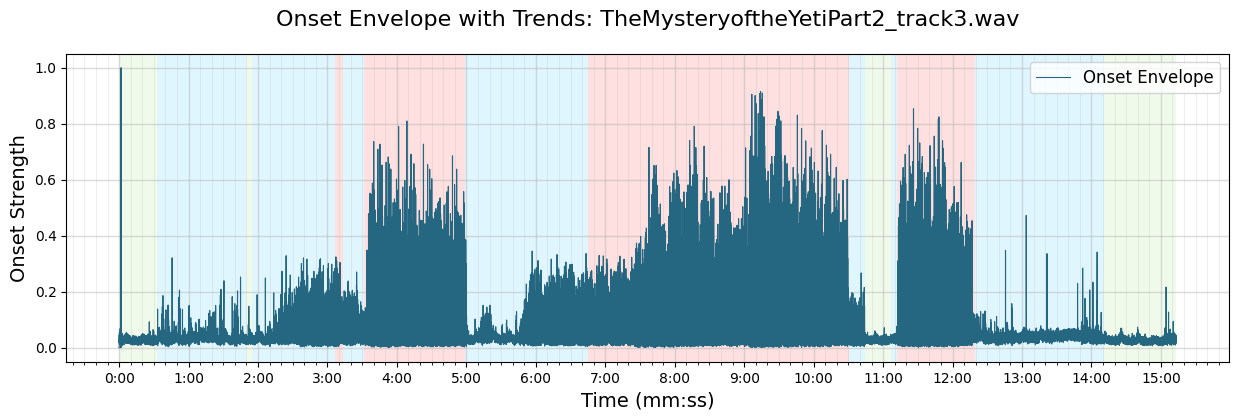

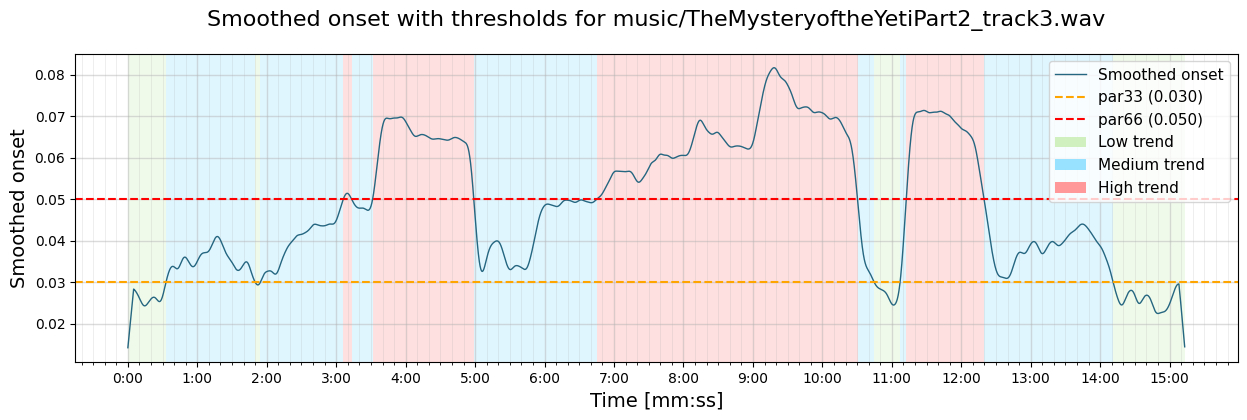

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
from matplotlib.patches import Patch


def plot_onset_with_trend(analyzer, dt=0.01):
    t_values = np.linspace(0, analyzer.duration, int(analyzer.duration / dt) + 1)

    onset_vals = []
    trend_vals = []

    for t in t_values:
        f = analyzer.features_at(t)
        onset_vals.append(f["onset"])
        trend_vals.append(f["trend"])

    onset_vals = np.array(onset_vals)
    trend_vals = np.array(trend_vals)

    trend_colors = np.array(['#d0f0c0', '#99e2ff', '#ff9999'])
    bg_colors = trend_colors[trend_vals]

    fig, ax = plt.subplots(figsize=(15, 4))

    for i in range(len(t_values) - 1):
        ax.axvspan(t_values[i], t_values[i + 1],
                   color=bg_colors[i], alpha=0.3, linewidth=0)

    ax.plot(t_values, onset_vals, color="#256680", label='Onset Envelope', lw=0.8)
    
    ax.xaxis.set_major_locator(MultipleLocator(60))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x//60)}:{int(x%60):02}"))


    ax.set_xlabel("Time (mm:ss)", fontsize=14)
    ax.set_ylabel("Onset Strength", fontsize=14)
    ax.set_title(
        f"Onset Envelope with Trends: {os.path.basename(audio_file)}",
        fontsize=16,
        pad=20
    )

    ax.grid(True, which="major", alpha=0.45, linewidth=1.0)
    ax.grid(True, which="minor", alpha=0.25, linewidth=0.6)
    ax.legend(fontsize=12, loc="upper right")


    plt.show()



def plot_smooth_onset_thresholds(analyzer: AudioAnalyzer):
    times = np.arange(len(analyzer.smoothed_onset)) * analyzer.hop / analyzer.sr
    smoothed = analyzer.smoothed_onset

    par33 = TRACK_PRESETS[analyzer.filename].par33
    par66 = TRACK_PRESETS[analyzer.filename].par66

    trend_vals = np.array([analyzer.features_at(t)["trend"] for t in times])
    trend_colors = np.array(['#d0f0c0', '#99e2ff', '#ff9999'])
    bg_colors = trend_colors[trend_vals]

    fig, ax = plt.subplots(figsize=(15, 4))

    for i in range(len(times) - 1):
        ax.axvspan(times[i], times[i + 1],
                   color=bg_colors[i], alpha=0.3, linewidth=0)

    ax.plot(times, smoothed, label="Smoothed onset", color="#256680", lw=1.0)
    ax.xaxis.set_major_locator(MultipleLocator(60))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x//60)}:{int(x%60):02}"))

    ax.axhline(par33, color="orange", linestyle="--", label=f"par33 ({par33:.3f})")
    ax.axhline(par66, color="red", linestyle="--", label=f"par66 ({par66:.3f})")



    ax.set_xlabel("Time [mm:ss]", fontsize=14)
    ax.set_ylabel("Smoothed onset", fontsize=14)
    ax.set_title(
        f"Smoothed onset with thresholds for {analyzer.filename}",
        fontsize=16,
        pad=20
    )


    ax.grid(True, which="major", alpha=0.45, linewidth=1.0)
    ax.grid(True, which="minor", alpha=0.25, linewidth=0.6)

    trend_legend = [
        Patch(facecolor="#d0f0c0", edgecolor="none", label="Low trend"),
        Patch(facecolor="#99e2ff", edgecolor="none", label="Medium trend"),
        Patch(facecolor="#ff9999", edgecolor="none", label="High trend"),
    ]

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles + trend_legend,
        labels + [p.get_label() for p in trend_legend],
        loc="upper right",
        fontsize=11
    )

    plt.show()

plot_onset_with_trend(analyzer)
plot_smooth_onset_thresholds(analyzer)


<h2>Beat tracking </h2>

Tempo - estimated BPM (is usually roughly constant across a single track in psytrace genre).

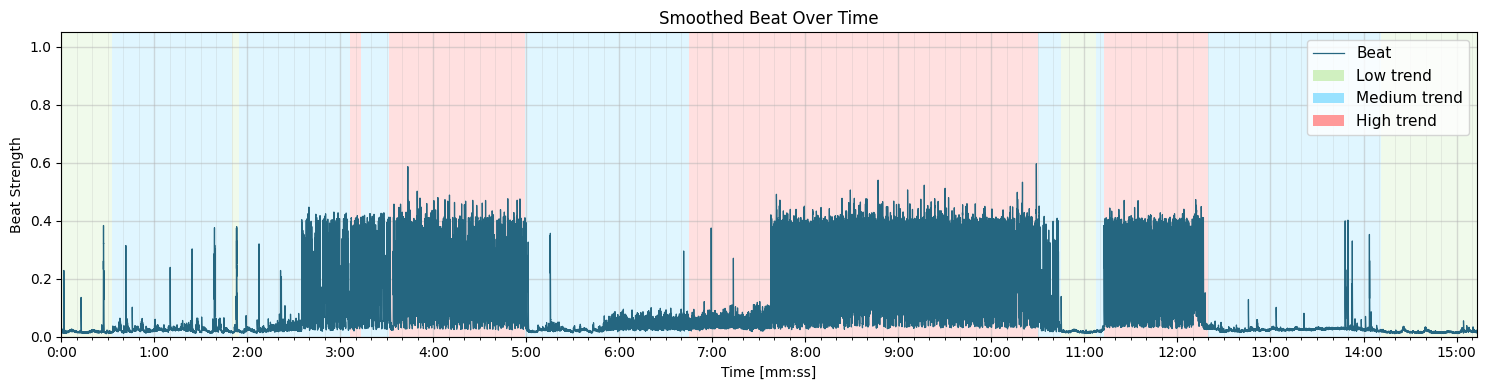

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
from matplotlib.patches import Patch

def plot_beat(analyzer, dt=0.01):
    t_values = np.linspace(0, analyzer.duration, int(analyzer.duration / dt) + 1)
    beat_vals = np.array([analyzer.features_at(t)["beat"] for t in t_values])

    trend_vals = np.array([analyzer.features_at(t)["trend"] for t in t_values])
    trend_colors = np.array(['#d0f0c0', '#99e2ff', '#ff9999'])
    bg_colors = trend_colors[trend_vals]

    fig, ax = plt.subplots(figsize=(15, 4))

    for i in range(len(t_values) - 1):
        ax.axvspan(
            t_values[i], t_values[i + 1],
            color=bg_colors[i],
            alpha=0.3,
            linewidth=0
        )

    ax.plot(t_values, beat_vals, color="#256680", label='Beat', lw=0.9)

    ax.set_ylim(0, 1.05)
    ax.set_title("Smoothed Beat Over Time")
    ax.set_ylabel("Beat Strength")
    ax.set_xlabel("Time [mm:ss]")

    ax.xaxis.set_major_locator(MultipleLocator(60))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: f"{int(x//60)}:{int(x%60):02}")
    )
    ax.set_xlim(0, analyzer.duration)

    ax.grid(True, which="major", alpha=0.45, linewidth=1.0)
    ax.grid(True, which="minor", alpha=0.25, linewidth=0.6)


    trend_legend = [
        Patch(facecolor="#d0f0c0", edgecolor="none", label="Low trend"),
        Patch(facecolor="#99e2ff", edgecolor="none", label="Medium trend"),
        Patch(facecolor="#ff9999", edgecolor="none", label="High trend"),
    ]

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles + trend_legend,
        labels + [p.get_label() for p in trend_legend],
        fontsize=11,
        loc="upper right"
    )

    plt.tight_layout()
    plt.show()

plot_beat(analyzer)

Lastnosti, ki jih vrne funkcija

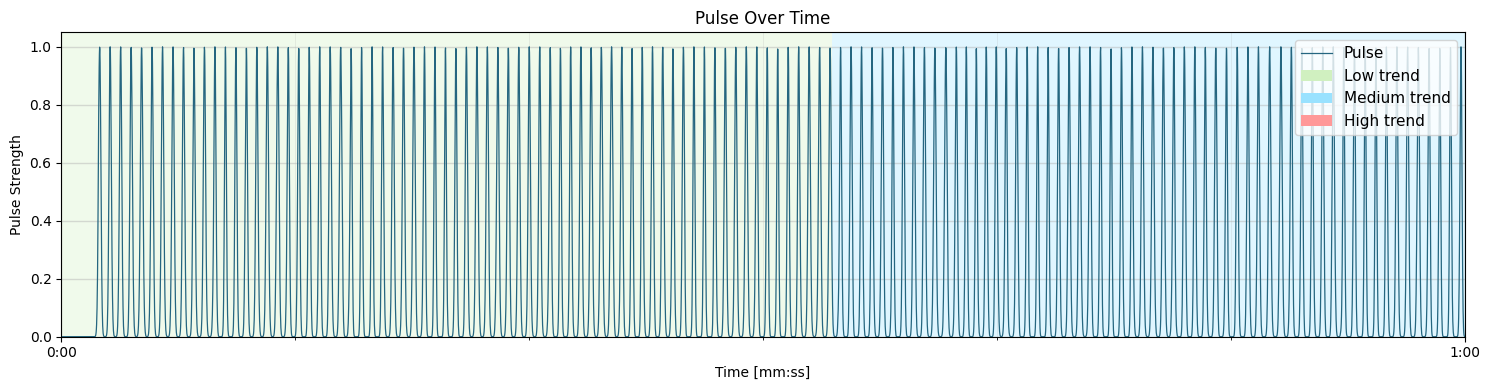

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter
from matplotlib.patches import Patch

def plot_pulse(analyzer, dt=0.01, max_duration=60):
    t_values = np.linspace(0, analyzer.duration, int(analyzer.duration / dt) + 1)
    
    t_values = t_values[t_values <= max_duration]

    pulse_vals = np.array([analyzer.features_at(t)["pulse"] for t in t_values])

    trend_vals = np.array([analyzer.features_at(t)["trend"] for t in t_values])
    trend_colors = np.array(['#d0f0c0', '#99e2ff', '#ff9999'])
    bg_colors = trend_colors[trend_vals]

    fig, ax = plt.subplots(figsize=(15, 4))

    for i in range(len(t_values) - 1):
        ax.axvspan(
            t_values[i], t_values[i + 1],
            color=bg_colors[i],
            alpha=0.3,
            linewidth=0
        )

    ax.plot(t_values, pulse_vals, color="#256680", label='Pulse', lw=0.9)

    ax.set_ylim(0, 1.05)
    ax.set_title("Pulse Over Time")
    ax.set_ylabel("Pulse Strength")
    ax.set_xlabel("Time [mm:ss]")

    ax.xaxis.set_major_locator(MultipleLocator(60))
    ax.xaxis.set_minor_locator(MultipleLocator(10))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: f"{int(x//60)}:{int(x%60):02}")
    )

    ax.set_xlim(0, min(max_duration, analyzer.duration))
    ax.grid(True, which="major", alpha=0.45, linewidth=1.0)
    ax.grid(True, which="minor", alpha=0.25, linewidth=0.6)

    trend_legend = [
        Patch(facecolor="#d0f0c0", edgecolor="none", label="Low trend"),
        Patch(facecolor="#99e2ff", edgecolor="none", label="Medium trend"),
        Patch(facecolor="#ff9999", edgecolor="none", label="High trend"),
    ]

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(
        handles + trend_legend,
        labels + [p.get_label() for p in trend_legend],
        fontsize=11,
        loc="upper right"
    )

    plt.tight_layout()
    plt.show()

plot_pulse(analyzer)

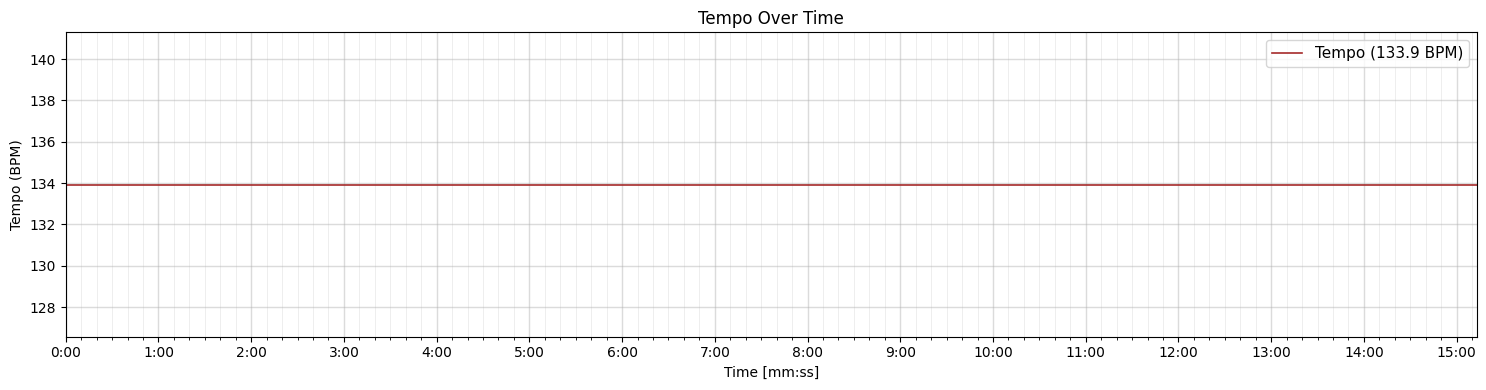

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FuncFormatter

def plot_tempo(analyzer):
    t_values = np.linspace(0, analyzer.duration, 1000)  
    tempo_vals = np.full_like(t_values, analyzer.tempo, dtype=float)

    fig, ax = plt.subplots(figsize=(15, 4))
    ax.plot(t_values, tempo_vals, color='brown', label=f'Tempo ({analyzer.tempo:.1f} BPM)', lw=1.2)

    ax.set_xlabel("Time [mm:ss]")
    ax.set_ylabel("Tempo (BPM)")
    ax.set_title("Tempo Over Time")

    ax.grid(True, which="major", alpha=0.45, linewidth=1.0)
    ax.grid(True, which="minor", alpha=0.25, linewidth=0.6)

    ax.legend(loc="upper right", fontsize=11)

    ax.xaxis.set_major_locator(MultipleLocator(60))   
    ax.xaxis.set_minor_locator(MultipleLocator(10)) 
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x//60)}:{int(x%60):02}"))

    ax.set_xlim(0, analyzer.duration)

    plt.tight_layout()
    plt.show()

plot_tempo(analyzer)
